In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from tqdm.notebook import tqdm, trange

In [32]:
%load_ext autoreload
%autoreload 2

from hex_show import *
from hex_pathfinding import *
from hex_helpers import *
from hex_minmax import *
from hex_train_helpers import *

bsize=6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialisierung

In [33]:

class RandomPlayer:
    @staticmethod
    def findmove(board):
        while True:
            k = np.random.randint(N**2)
            if board[divmod(k,N)]==0:
                return divmod(k,N)

## Pitting

In [34]:
# Funktion für das pitten zweier ai`s (Wettkampf mit n Runden)

def pit(ai1, ai2, n=20, nrnd=0, verbose=0):
    '''Pits two ai for n rounds. First nrnd moves are randomly chosen.
    confidence: sigma interval in where you want to know one ai is better than the other
    '''
        
    if type(n) is type(None) or n==np.Inf:
        n = int(1e10)
    
    wins1 = 0
    wins2 = 0
    
    for k in range(n):

        if k%2 == 0:
            ai_red  = ai1
            ai_blue = ai2
        else:
            ai_red  = ai2
            ai_blue = ai1
            
        if k%2 == 0:
            board0 = filledboard(bsize, nrnd)
            
        board = board0.copy()
        turn = (-1)**(board!=0).sum()

        while True:

            if turn>0:
                #'Reds turn'

                # Move by an AI
                #x, y = ai_red.findmove(board, True, verbose=0)
                x, y = ai_red.findmove(board)

            else:
                #'Blues turn'

                # Move by an AI
                #x, y = ai_blue.findmove(board, False, verbose=0)
                x, y = ai_blue.findmove(board)


            board[x,y] = turn
            turn *= -1


            # If someone has won
            won = winner(board)
            if won!=0:
                break

        if k%2==1:
            won *= -1
        wins1 += int(+won/2+1/2)
        wins2 += int(-won/2+1/2)
        sigma = np.sqrt(wins1*wins2/(wins1+wins2))
        
        if verbose:
            print(wins1, k+1)
        
        
    #return wins1, wins2
    return wins1/n

## Training

In [35]:

# Batch generator for neural network training

def batchgen(gamerecords, size=50, istart=0, verbose=None):
    '''size: minibatchsize
    istart, iend: Start- und Endindex der herausgegebenen Samples
    verbose: Wenn überschrieben, dann mit einem String des Batchgen Namens (z. B. Supervised)'''
    ep = 0
    iend = len(gamerecords)
    while True:
        ilist = range(istart, iend)
        ilist = np.random.permutation(ilist)
        minibatches = [ ilist[k*size:(k+1)*size] for k in range(len(ilist)//size) ]
        for mb in minibatches:
            xs = np.zeros((size, 3, N, N))
            y1s = np.zeros((size, 1, N, N))
            y2s = np.zeros((size, 1))
            y3s = np.zeros((size, 1, N, N))
            for i, k in enumerate(mb):
                x, y1, y2, y3 = gamerecords[k]
                xs[i] = encode_oh(x)
                ii,jj = y1
                y1s[i, 0, ii, jj] = 1
                y2s[i] = y2
                y3s[i, 0] = y3
            yield xs, y1s, y2s, y3s
        if verbose:
            print(f'{verbose}: finished one epoch ({ep})!')
        ep += 1
    
    

def train(net, gamerecords, gamerecords_legacy, iterations=4000, aug_ds=True, cons_ds=True, verbose=0):
    '''Trainiert das Netz
    aug_ds: Augmentation durch Drehspiegelung (Flip in x und y)
    cons_ds: Konsistenzbedingung unter Drehspiegelung auf dem unsupervised Set
    teacher_function: Eine Funktion, nach der auf dem unsupervised Set das Netzwerk trainiert wird. Wenn None wird der MTeacher genutzt'''

    #if net is None:
    #    net = Net(n=64)
    ##net.train()
    optimizer = torch.optim.Adam(lr=1e-3, params=net.parameters(), weight_decay=1e-4)
    bg_s = batchgen(gamerecords)                             #### istart erhöhen um valbatch zu haben? für early stopping?
    bg_u = batchgen(gamerecords_legacy, size=150)
    BCE = nn.BCELoss()
    MSE = nn.MSELoss()
    L1Loss = nn.L1Loss()
    LogLoss = lambda yp, yt: torch.mean(-yt*torch.log(yp+1e-4))
    losses = []
    semlosses = []
    mtlosses = []

    # Validation batches
    #...
    
    # Trainings loop
    vloss_min = np.Inf
    for k in trange(iterations):

        # ==== Supervised step ====
        b, tp, tv, tpath = next(bg_s)
        b, tp, tv, tpath = batch2torch(b, tp, tv, tpath)
        
        if aug_ds:
            if np.random.rand()<0.5:
                b = torch.flip(b, [2, 3])
                tp = torch.flip(tp, [2, 3])
                tpath = torch.flip(tpath, [2, 3])
            
        pp, pv, ppath = net(b, withpath=True)
        # For softmax LogLoss, for sigmoid BCE
        loss = LogLoss(pp.view(-1), tp.view(-1)) + MSE(pv, tv)
        loss += 0.01 * BCE(ppath.view(-1), tpath.view(-1))
        loss.backward()
        loss = loss.item() # torch to float

        # ==== Unsupervised step ====
        if cons_ds:
            b1, _, _, _ = batch2torch(*next(bg_u))
            b2 = b1   # Kopie von x für Rauschen oder Veränderung

            # --> welche augmentation / noise ?
            if cons_ds:
                b2 = torch.flip(b2, [2, 3])

            # --> welches Netzwerk ?
            pp1, pv1, ppath1 = net(b1, withpath=True)
            pp2, pv2, ppath2 = net(b2, withpath=True)
                
            if cons_ds:
                pp2 = torch.flip(pp2, [2, 3]) ## flip back
                ppath2 = torch.flip(ppath2, [2, 3])
            semloss  = MSE(pp1.view(-1), pp2.view(-1)) + MSE(pv1, pv2)
            semloss += 0.01 * MSE(ppath1, ppath2)
            
            semloss *= 2
            semloss.backward()
            semloss = semloss.item()
        else:
            semloss = 0
            

        # do the training step on the network
        optimizer.step()
        optimizer.zero_grad()
            
        # Statistic
        losses += [loss]
        semlosses += [semloss]
        
        # Verbose output, measure minimum val loss
        if len(losses) == 100:
            if verbose>=1:
                print('Loss=%f, SSLoss=%f'% (np.mean(losses), np.mean(semlosses)))
            losses = []

        if k % 200 == 0 and verbose>=2:
            board, value = collection[0]
            v_est = net.predict(encode_oh(board))

            show_board(v_est, cmap='cividis')
            plt.show()
            
    return net

### Selfplay

In [36]:
from hex_minmax import *
from hex_nnet import *
from hex_mcts import *

bsize = 6



import pickle


def selfplay(ai, ngames=1000, verbose=0):
    
    red_wins = 0
    blue_wins = 0
    games_record = []

    # Iterator with tqdm??
    iter = range(ngames)
    if verbose>=1:
        iter = tqdm(iter)
        
    # Play n games!
    for k in iter:

        ##ai = MultiMCTS(nparallel=5, nsearches=50, path='net_train_selfplay.dat')
        ai.eta = 0.3
        ai_red = ai
        ai_blue = ai

        #### #  Spiele aufzeichnen
        boards_moves_record = []
        ####

        #board = np.zeros((bsize,bsize), int)
        board = filledboard(bsize, 3)
        turn = getturn(board)

        while True:

            #show_board(board)
            #plt.show()


            if turn>0:
                #print('Reds turn')

                # Move by an AI
                x, y = ai_red.findmove(board)


            else:
                #print('Blues turn')

                # Move by an AI
                x, y = ai_blue.findmove(board)

            if turn > 0:
                boards_moves_record += [(board.copy(), (x,y), turn)]
            else:
                boards_moves_record += [(-board.T.copy(), (y,x), turn)]
                

            board[x,y] = turn
            turn *= -1



            # If someone has won
            won = winner(board)
            if won!=0:
                if verbose >= 2:
                    if won==+1:
                        print('Red has won!')
                    else:
                        print('Blue has won!')
                if verbose >= 3:
                    show_board(board)
                    show_path(path)
                    plt.show()
                break

        red_wins  += int(+won/2+1/2)
        blue_wins += int(-won/2+1/2)

        winpath = winning_path(board)
        path = np.zeros((N,N), dtype='uint8')
        for i,j in winpath:
            path[i,j] = 1

        # Spiele aufzeichnen
        boards_won_record = [ (b, m, t*won, path if t>0 else path.T) for b, m, t in boards_moves_record ]
        ## irgendwann winning path hinzufügen?

        games_record += boards_won_record
        
    return games_record

In [37]:
from hex_minmax import *
from hex_mcts import *

bsize = 6



import pickle


def selfplay_batched(ai, ngames=1000, verbose=0):
    
    bnum = ai.nparallel
    game_records = []
    
    ai.eta = 0.3

    # Iterator with tqdm??
    if verbose>=1:
        pbar = tqdm(total=ngames)
        
    newboard = lambda: filledboard(bsize, count=3)
    boards = [ newboard() for _ in range(bnum) ]
    turns = [ getturn(brd) for brd in boards ]
    records = [ [] for _ in range(bnum) ]
    
    
    completedgames = 0
    while completedgames < ngames:
        
        moves = ai.findmove(boards)
        for b in range(bnum):
            turn = turns[b]
            x, y = moves[b]
            records[b] += [(boards[b].copy(), (x, y), turn)] if turn > 0 else \
                          [(-boards[b].T.copy(), (y, x), turn)]
            boards[b][x, y] = turns[b]
            turns[b] *= -1
            
            won = winner(boards[b])
            if won:
                winpath = winning_path(boards[b])
                path = np.zeros((N,N), dtype='uint8')
                for i,j in winpath:
                    path[i,j] = 1
                game_records += [ (b, m, t*won, path if t>0 else path.T) for (b, m, t) in records[b] ]
                completedgames += 1
                records[b] = []
                boards[b] = newboard()
                turns[b] = getturn(boards[b])
                if verbose>=1:
                    pbar.update(1)
    
    if verbose>=1:
        pbar.close()
        
    return game_records

In [128]:
#newgames = selfplay(MultiMCTS(nparallel=1, nsearches=50, net=net), ngames=200, verbose=1)  # 25 min für 200 games!
#newgames = selfplay(MultiMCTS(nparallel=10, nsearches=50, net=net), ngames=200, verbose=1)  #  5 min für 200 games! batching verschlechtert spielperformance ein wenig!
#newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1) # 3 min für 200 games!

In [38]:
    
class Net(nn.Module):
    def __init__(self, n=64, ksize=3, bn=True, dropout_rate=0.2):
        super().__init__()
        
        # Initiate all layers of this network
        # shared layers
        self.conv1 = nn.Conv2d(3, n, 3, padding=1)
        self.resblock1 = ResBlock(n, sz=ksize, bn=bn)
        self.resblock21 = ResBlock(2*n, sz=ksize, bn=bn)
        self.resblock22 = ResBlock(2*n, sz=ksize, bn=bn)
        self.resblock23 = ResBlock(2*n, sz=ksize, bn=bn)
        self.down1 = ResBlockDown(n, 2*n)
        
        # policy head
        self.p_resblock3 = ResBlock(n, sz=ksize, bn=bn)
        self.p_up1 = ResBlockUp(2*n, n)
        self.p_conv_m1 = nn.Conv2d(n, 1, 3, padding=1)
        
        # policy head
        self.path_resblock3 = ResBlock(n, sz=ksize, bn=bn)
        self.path_up1 = ResBlockUp(2*n, n)
        self.path_conv_m1 = nn.Conv2d(n, 1, 3, padding=1)
        
        # value head
        self.v_dense1 = nn.Linear((N//2)**2 * 2*n, 1024)
        self.v_dense2 = nn.Linear(1024, 512)
        self.v_dense3 = nn.Linear(512, 1)
        self.v_dropout = nn.Dropout(p=dropout_rate)
        
        
        # Move network to GPU
        if GPU:
            self.cuda()
        
    def forward(self, x, withpath=False):
        x = relu(self.conv1(x))
        x = self.resblock1(x)
        
        xskip_1 = x
        
        x = self.down1(x)
        x = self.resblock21(x)
        x = self.resblock22(x)
        x = self.resblock23(x)
        
        # p-Block
        y1 = self.p_up1(x)
        y1 += xskip_1
        y1 = self.p_resblock3(y1)
        
        y1 = self.p_conv_m1(y1)
        b, c, h, w = y1.shape
        y1 = y1.view(b, c*h*w)
        y1 = softmax(y1)
        y1 = y1.view(b, c, h, w)
        
        
        # v-Block
        n, c, h, w = x.shape
        y2 = x.view(n, c*h*w)
        y2 = relu(self.v_dense1(y2))
        y2 = self.v_dropout(y2)
        y2 = relu(self.v_dense2(y2))
        y2 = self.v_dropout(y2)
        y2 = tanh(self.v_dense3(y2))
        
        if withpath:
            # path-Block
            y3 = self.path_up1(x)
            y3 += xskip_1
            y3 = self.path_resblock3(y3)

            y3 = self.path_conv_m1(y3)
            y3 = sigmoid(y3)

            return y1, y2, y3
        
        else:
            return y1, y2
    
    @staticmethod
    def encode_oh(x):
        'Encodes the board in one hot format (blue stone, red stone, no stone)'
        x_oh = np.zeros((3, N, N))
        for n in range(3):
            x_oh[n, :, :] = (x == n)
        return x_oh
    
    
    def predict(self, numpy_x):
        'Takes a numpy array and give out v and a p array.'
        numpy_x = self.encode_oh(numpy_x)
        x = torch.from_numpy(numpy_x[None,:].astype('float32'))
        if GPU:
            x = x.cuda()
        y1, y2 = self(x)
        y1 = y1[0,0,:,:].detach().cpu().numpy()
        y2 = y2.item()
        return y1, y2
    
    
    def predictStack(self, numpy_x):
        'Does a prediction on a stack of states'
        b = len(numpy_x)
        xs = []
        for nx in numpy_x:
            xs += [self.encode_oh(nx)]
        xs = np.asarray(xs)
        xs = torch.from_numpy(xs.astype('float32'))
        if GPU:
            xs = xs.cuda()
        y1, y2 = self(xs)
        y1 = y1[:,0,:,:].detach().cpu().numpy()
        y2 = y2[:,0].detach().cpu().numpy()
        return y1, y2
    

In [39]:

net = Net()
game_rec = selfplay(RandomPlayer(), ngames=400, verbose=1)
game_rec_leg = selfplay(RandomPlayer(), ngames=1200, verbose=1)
print(f'Game record / legacy has length {len(game_rec)} / {len(game_rec_leg)}')
net = train(net, game_rec, game_rec_leg, iterations=1000, verbose=1)
winrates = []
mmdepths = []
depthminimax = 1
stage = 0


Game record / legacy has length 11198 / 33453


Loss=1.125908, SSLoss=0.007808
Loss=1.079109, SSLoss=0.006527
Loss=1.052168, SSLoss=0.008169
Loss=1.022562, SSLoss=0.010005
Loss=0.993368, SSLoss=0.013073
Loss=0.967701, SSLoss=0.016100
Loss=0.938678, SSLoss=0.019070
Loss=0.879670, SSLoss=0.022833
Loss=0.837405, SSLoss=0.026139
Loss=0.791121, SSLoss=0.030219



Pitting
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0.0


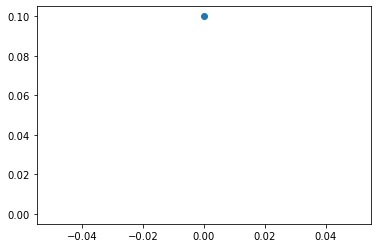

Training


Loss=0.749936, SSLoss=0.058317
Loss=0.681637, SSLoss=0.065114
Loss=0.629304, SSLoss=0.070896

Selfplay



number of new states: 3617
size of game rec / game rec legacy): 14815 33453
Pitting
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0.0


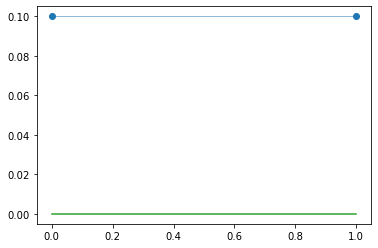

Training


Loss=0.735706, SSLoss=0.068312
Loss=0.714743, SSLoss=0.069054
Loss=0.686131, SSLoss=0.069922

Selfplay



number of new states: 2935
size of game rec / game rec legacy): 17750 33453
Pitting
0 1
0 2
0 3
0 4
0 5
0 6
1 7
2 8
2 9
2 10
0.2


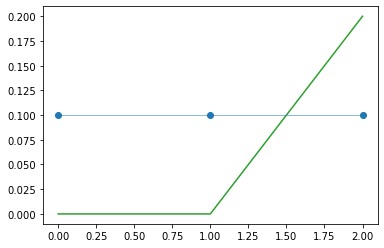

Training


Loss=0.715650, SSLoss=0.072728
Loss=0.683210, SSLoss=0.073482
Loss=0.681282, SSLoss=0.073996

Selfplay



number of new states: 2828
size of game rec / game rec legacy): 20578 33453
Pitting
0 1
0 2
1 3
1 4
1 5
2 6
2 7
3 8
4 9
5 10
0.5


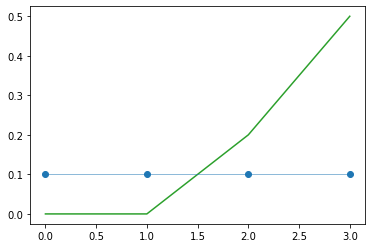

Training


Loss=0.718840, SSLoss=0.069134
Loss=0.686141, SSLoss=0.072116
Loss=0.679582, SSLoss=0.071693

Selfplay



number of new states: 2907
size of game rec / game rec legacy): 23485 33453
Pitting
0 1
1 2
2 3
3 4
3 5
4 6
5 7
6 8
7 9
7 10
0.7


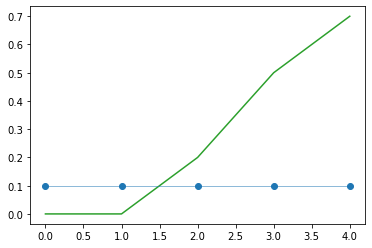

Changing minimax depth to 2
Training


Loss=0.684373, SSLoss=0.069401
Loss=0.677551, SSLoss=0.071084
Loss=0.659105, SSLoss=0.070247

Selfplay



number of new states: 2685
size of game rec / game rec legacy): 26170 33453
Pitting
1 1
1 2
1 3
2 4
2 5
2 6
3 7
4 8
5 9
5 10
0.5


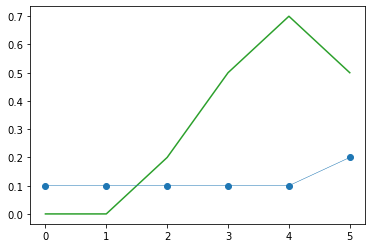

Training


Loss=0.648382, SSLoss=0.073574
Loss=0.652978, SSLoss=0.072348
Loss=0.650785, SSLoss=0.071164

Selfplay



number of new states: 2335
size of game rec / game rec legacy): 28505 33453
Pitting
0 1
0 2
1 3
1 4
1 5
2 6
3 7
4 8
5 9
6 10
0.6


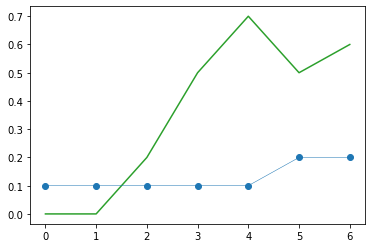

Training


Loss=0.620609, SSLoss=0.070660
Loss=0.632593, SSLoss=0.068329
Loss=0.631479, SSLoss=0.067027

Selfplay



number of new states: 2414
size of game rec / game rec legacy): 30000 34372
Pitting
1 1
2 2
2 3
3 4
3 5
4 6
4 7
5 8
6 9
7 10
0.7


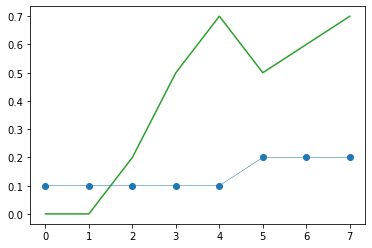

Changing minimax depth to 3
Training


Loss=0.609568, SSLoss=0.066899
Loss=0.607414, SSLoss=0.066361
Loss=0.616834, SSLoss=0.062610

Selfplay



number of new states: 2501
size of game rec / game rec legacy): 30000 36873
Pitting
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
0.1


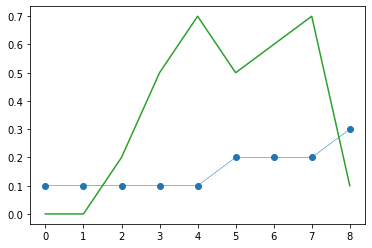

Training


Loss=0.593541, SSLoss=0.058594
Loss=0.587303, SSLoss=0.056541
Loss=0.577925, SSLoss=0.057292

Selfplay



number of new states: 2620
size of game rec / game rec legacy): 30000 39493
Pitting
0 1
0 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
2 10
0.2


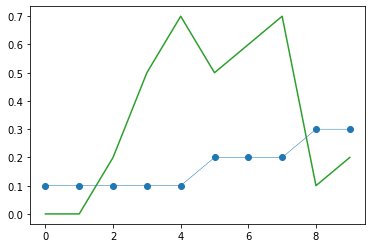

Training


Loss=0.583230, SSLoss=0.050506
Loss=0.560760, SSLoss=0.049893
Loss=0.552285, SSLoss=0.049651

Selfplay



number of new states: 2490
size of game rec / game rec legacy): 30000 41983
Pitting
0 1
1 2
1 3
2 4
3 5
4 6
4 7
5 8
6 9
7 10
0.7


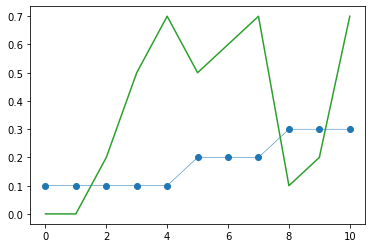

Changing minimax depth to 4
Training


Loss=0.557673, SSLoss=0.041997
Loss=0.563431, SSLoss=0.039487
Loss=0.542242, SSLoss=0.039251

Selfplay



number of new states: 2565
size of game rec / game rec legacy): 30000 44548
Pitting
0 1
0 2
1 3
2 4
2 5
2 6
3 7
3 8
4 9
4 10
0.4


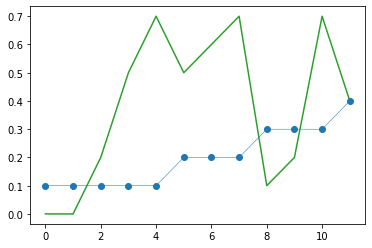

Training


Loss=0.541839, SSLoss=0.029860
Loss=0.537044, SSLoss=0.027747
Loss=0.536137, SSLoss=0.025781

Selfplay



number of new states: 2571
size of game rec / game rec legacy): 30000 47119
Pitting
0 1
1 2
1 3
2 4
3 5
4 6
4 7
4 8
5 9
5 10
0.5


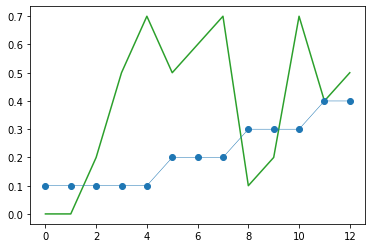

Training


Loss=0.514738, SSLoss=0.026075
Loss=0.485347, SSLoss=0.026264
Loss=0.493306, SSLoss=0.025085

Selfplay



number of new states: 2565
size of game rec / game rec legacy): 30000 49684
Pitting
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 8
2 9
3 10
0.3


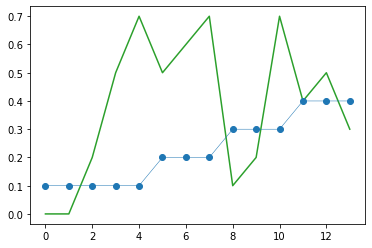

Training


Loss=0.438490, SSLoss=0.029420
Loss=0.445630, SSLoss=0.027829
Loss=0.426443, SSLoss=0.027557

Selfplay



number of new states: 2558
size of game rec / game rec legacy): 30000 52242
Pitting
1 1
2 2
2 3
2 4
3 5
4 6
4 7
5 8
6 9
7 10
0.7


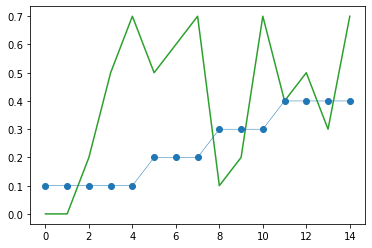

Training


Loss=0.410863, SSLoss=0.029385
Loss=0.394268, SSLoss=0.028562
Loss=0.391044, SSLoss=0.027954

Selfplay



number of new states: 2573
size of game rec / game rec legacy): 30000 54815
Pitting
0 1
0 2
0 3
0 4
1 5
2 6
2 7
3 8
3 9
4 10
0.4


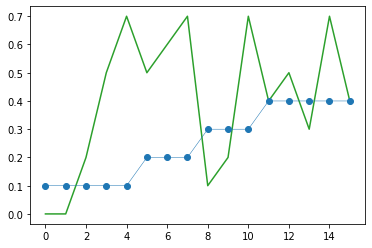

Training


Loss=0.352139, SSLoss=0.032713
Loss=0.347180, SSLoss=0.031193
Loss=0.374103, SSLoss=0.030030

Selfplay



number of new states: 2564
size of game rec / game rec legacy): 30000 57379
Pitting
1 1
1 2
2 3
2 4
2 5
2 6
3 7
3 8
3 9
3 10
0.3


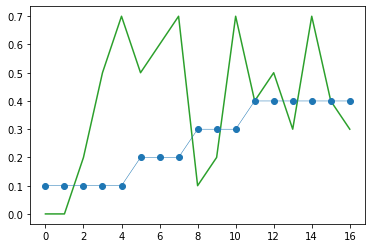

Training


Loss=0.338988, SSLoss=0.029660
Loss=0.338145, SSLoss=0.029661
Loss=0.327220, SSLoss=0.028889

Selfplay



number of new states: 2588
size of game rec / game rec legacy): 30000 59967
Pitting
1 1
2 2
3 3
3 4
4 5
4 6
5 7
6 8
7 9
8 10
0.8


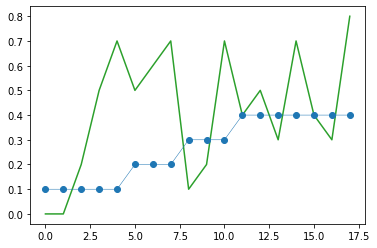

Training


Loss=0.315489, SSLoss=0.031530
Loss=0.314457, SSLoss=0.030593
Loss=0.313364, SSLoss=0.029876

Selfplay



number of new states: 2664
size of game rec / game rec legacy): 30000 62631
Pitting
0 1
1 2
2 3
2 4
3 5
3 6
4 7
4 8
4 9
4 10
0.4


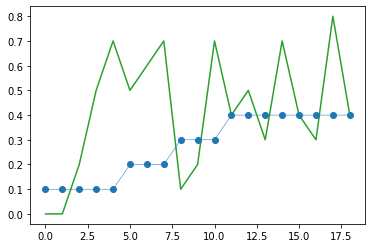

Training


Loss=0.314295, SSLoss=0.029626
Loss=0.306245, SSLoss=0.029559
Loss=0.321628, SSLoss=0.029088

Selfplay



number of new states: 2774
size of game rec / game rec legacy): 30000 65405
Pitting
0 1
0 2
1 3
2 4
3 5
3 6
4 7
4 8
4 9
4 10
0.4


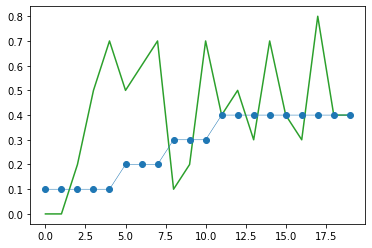

Training


Loss=0.334137, SSLoss=0.033167
Loss=0.332721, SSLoss=0.032126
Loss=0.319870, SSLoss=0.031354

Selfplay



number of new states: 3031
size of game rec / game rec legacy): 30000 68436
Pitting
1 1
2 2
2 3
3 4
4 5
5 6
6 7
6 8
7 9
8 10
0.8


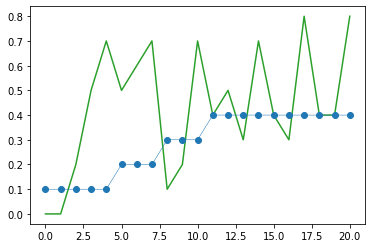

Training


Loss=0.370076, SSLoss=0.032653
Loss=0.328571, SSLoss=0.031450
Loss=0.346386, SSLoss=0.030519

Selfplay



number of new states: 2878
size of game rec / game rec legacy): 30000 71314
Pitting
1 1
1 2
1 3
2 4
3 5
4 6
5 7
6 8
7 9
7 10
0.7


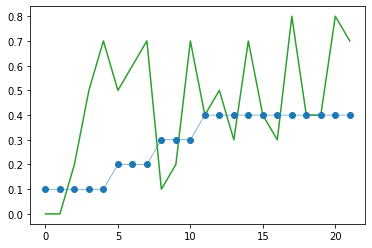

Training


Loss=0.373324, SSLoss=0.031454
Loss=0.355257, SSLoss=0.030781
Loss=0.356543, SSLoss=0.030947

Selfplay



number of new states: 2964
size of game rec / game rec legacy): 30000 74278
Pitting
1 1
1 2
2 3
3 4
4 5
4 6
5 7
6 8
7 9
7 10
0.7


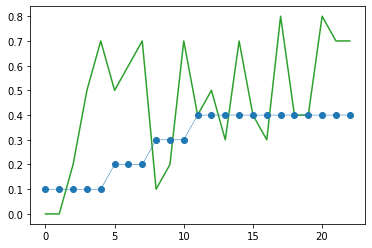

Training


Loss=0.383576, SSLoss=0.033500
Loss=0.390412, SSLoss=0.031956
Loss=0.372472, SSLoss=0.031572

Selfplay



number of new states: 3052
size of game rec / game rec legacy): 30000 77330
Pitting
1 1
2 2
3 3
4 4
5 5
6 6
7 7
7 8
8 9
9 10
0.9


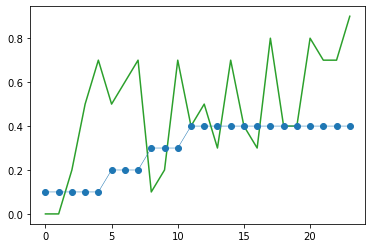

Training


Loss=0.386889, SSLoss=0.033164
Loss=0.384176, SSLoss=0.032850
Loss=0.385426, SSLoss=0.033126

Selfplay



number of new states: 2926
size of game rec / game rec legacy): 30000 80256
Pitting
0 1
1 2
2 3
3 4
4 5
4 6
5 7
6 8
6 9
6 10
0.6


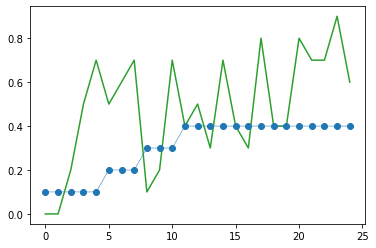

Training


Loss=0.393607, SSLoss=0.037432
Loss=0.398033, SSLoss=0.035406
Loss=0.397386, SSLoss=0.035427

Selfplay



number of new states: 2922
size of game rec / game rec legacy): 30000 83178
Pitting
1 1
2 2
2 3
2 4
3 5
3 6
4 7
5 8
6 9
6 10
0.6


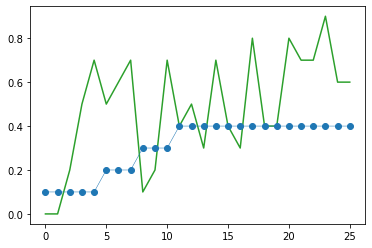

Training


Loss=0.379784, SSLoss=0.035895
Loss=0.416950, SSLoss=0.034905
Loss=0.398050, SSLoss=0.035321

Selfplay



number of new states: 2901
size of game rec / game rec legacy): 30000 86079
Pitting
1 1
1 2
2 3
2 4
2 5
3 6
3 7
3 8
4 9
5 10
0.5


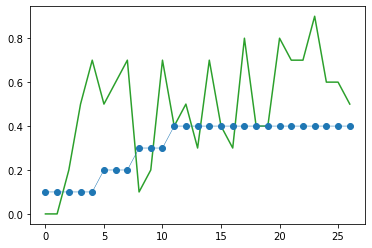

Training


Loss=0.406529, SSLoss=0.036385
Loss=0.393384, SSLoss=0.036751
Loss=0.394187, SSLoss=0.036733

Selfplay


KeyboardInterrupt: 

In [40]:
## game_rec = []

#net = Net()
##net.load_state_dict(torch.load('net_train_selfplay.dat'))


#stage = 1

while True:

    
    # Evaluate/Pit
    if stage==0:
        print('Pitting')
        winrate = pit(MultiMCTS(nparallel=5, nsearches=150, net=net), MiniMax(maxdepth=depthminimax), n=10, nrnd=1, verbose=1)
        print(winrate)
        winrates.append(winrate)
        mmdepths.append(depthminimax)
        plt.plot(winrates, 'C2')
        plt.plot(np.array(mmdepths)/10, 'C0o-', lw=0.5)
        plt.show()
        if winrate>=0.7 and depthminimax<4:
            depthminimax += 1
            print(f'Changing minimax depth to {depthminimax}')
        stage = 1
    
    
    # Train
    if stage==1:
        print('Training')
        net = train(net, game_rec, game_rec_leg, iterations=300, verbose=1)
        torch.save(net.state_dict(), 'net_temp.dat')
        stage = 2
    
    
    # Selfplay
    if stage==2:
        print('Selfplay')
        #newgames = selfplay(MultiMCTS(nparallel=5, nsearches=50, net=net), ngames=200, verbose=1)
        newgames = selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1)
        game_rec = newgames + game_rec
        game_rec_leg = game_rec[30000:] + game_rec_leg
        game_rec_leg = game_rec_leg[:150000]
        game_rec = game_rec[:30000]
        print('number of new states:', len(newgames))
        print('size of game rec / game rec legacy):', len(game_rec), len(game_rec_leg))
        stage=0
    

In [17]:
import pickle as pkl
pkl.dump(game_rec, open('selfplay50.dat', 'wb'))

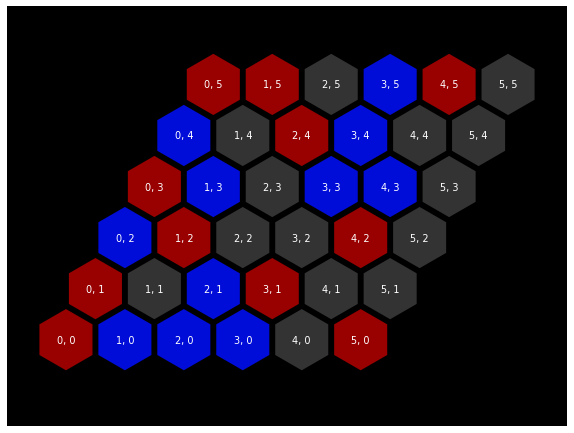

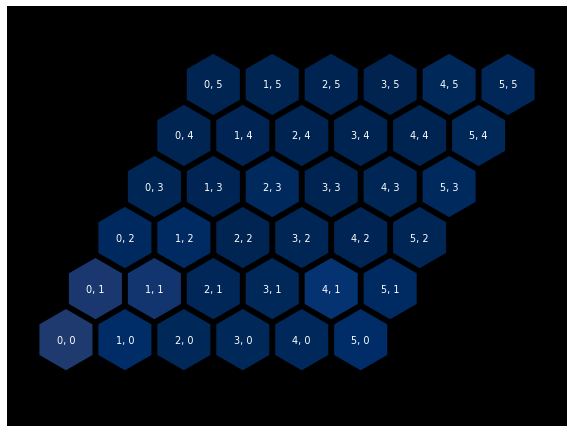

In [120]:
board = filledboard(6, .6)
oh = encode_oh(board)
p, v, path = net(np2t(oh[None,:]), withpath=True)
path = t2np(path[0])[0]
path

show_board(board)
show_board(path*5, cmap='cividis')

In [119]:
p

tensor([[[[0.0394, 0.0349, 0.0322, 0.0298, 0.0067, 0.0602],
          [0.0264, 0.0369, 0.0704, 0.0224, 0.0157, 0.0165],
          [0.0675, 0.0229, 0.0271, 0.0144, 0.0110, 0.0097],
          [0.0182, 0.0627, 0.0094, 0.0082, 0.0028, 0.0097],
          [0.0405, 0.0028, 0.0096, 0.0108, 0.0257, 0.1197],
          [0.0022, 0.0302, 0.0143, 0.0092, 0.0490, 0.0307]]]], device='cuda:0',
       grad_fn=<ViewBackward>)

In [ ]:
from hex_mcts import *
from hex_mcts_rave import MultiMCTS as MultiMCTSRAVE

In [ ]:
ai1 = MultiMCTSRAVE(net='net_selfplay150.dat', nparallel=10, timelimit=.5)
ai1.n_rave = 2

ai2 = MultiMCTS(net='net_selfplay150.dat', nparallel=10, timelimit=.5)

In [ ]:

board = filledboard(6, 1/3)
ai2.findmove(board, verbose=1)

In [ ]:
pit(ai1, ai2, nrnd=2, verbose=1)

In [ ]:
ai1 = MiniMax(maxdepth=3)
ai2 = MiniMax(maxdepth=3)

ai1.bridges=True

pit(ai1, ai2, nrnd=2, verbose=1)

In [98]:
from experiment import *
%load_ext line_profiler
%lprun -f MCTS.search_up selfplay_batched(BatchMCTS(nparallel=20, nsearches=50, net=net), ngames=200, verbose=1)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


*** KeyboardInterrupt exception caught in code being profiled.

In [93]:
pit(MCTS(nsearches=50, net=net), MiniMax(maxdepth=3), verbose=1)

1 1
1 2
2 3
3 4


KeyboardInterrupt: 